# AM207 - Long HW 1 


## Problem 1 - Stochastic Gradient Descent for Logistic Regression
### Part A

In [15]:
# -*- coding: utf-8 -*-

import theano
from theano import *
import theano.tensor as T
import pandas as pd
import numpy as np

import gzip, pickle, time
import numpy as np
import matplotlib.pyplot as plt


#======================#
#loading the dataset into notebook as well as theano GPU#
#======================#

dataset=r"C:\Users\Dell\Documents\Python Scripts\mnist.pkl.gz"
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

def shared_dataset(data_xy, borrow=True):
    data_x, data_y = data_xy
    shared_x = theano.shared(np.asarray(data_x,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    return shared_x, T.cast(shared_y, 'int32')
   
test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)


#=====================#
#set up parameters #
#=====================#
batch_size = 256
n_train_batches = train_set[0].shape[0] // batch_size
learning_rate = 0.1
L2_reg = 0.01




#creating the logistic regression class #
class LogisticRegression(object):

    def __init__(self, input, n_in, n_out):
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(
            value=np.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=np.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # symbolic description of how to compute prediction as class whose
        # probability is maximal
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        # end-snippet-1

        # parameters of the model
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input
        
        #computing sum of squares of paramters 
        self.L2_sqr = (self.W ** 2).sum()
         
    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        """

        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
        # end-snippet-2

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

            
    
x = T.matrix('x')  # data, presented as rasterized images
y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

#building on top of logistic regression 
classifier = LogisticRegression(input=x, n_in=28 * 28, n_out=10)


#cost function with L2 Regularization of lambda = 0.01 
cost = (classifier.negative_log_likelihood(y)
        + L2_reg * classifier.L2_sqr)

#taking the cost function to evaluate gradient
g_W = T.grad(cost=cost, wrt=classifier.W)
g_b = T.grad(cost=cost, wrt=classifier.b)
#updating the weights and errors vector 
updates = [(classifier.W, classifier.W - learning_rate * g_W),
           (classifier.b, classifier.b - learning_rate * g_b)]

# creating a training function that computes the cost and updates the parameter of the model based on the rules
index = T.lscalar()

train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

# recording the time at the beginning:
start_time = time.time()

#Run the model batch by batch and see how average cost decrease over time 
avg_cost = []

for minibatch_index in range(n_train_batches):
    minibatch_avg_cost = train_model(minibatch_index)
    avg_cost.append(minibatch_avg_cost.mean())
    
print("The algorithm takes %f seconds to run" % (time.time() - start_time))



The algorithm takes 0.129580 seconds to run


Let's visualize the change in average cost function:

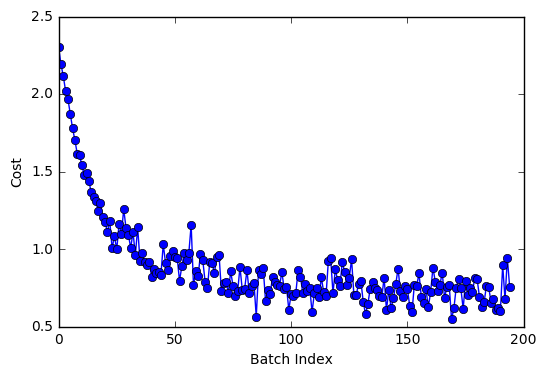

In [16]:
%matplotlib inline
#visualizing the average cost function 
plt.figure()
plt.plot(range(len(avg_cost)),avg_cost,marker = 'o')
plt.xlabel('Batch Index')
plt.ylabel('Cost')
